In [21]:
import cobra
import glob
import os
import time
import pandas as pd
from cobra.flux_analysis import pfba


In [22]:
def apply_constraints(model, constraints_dict):
    new_model = model.copy()
    for rid, (lb, ub) in constraints_dict.items():
        rxn = new_model.reactions.get_by_id(rid)
        rxn.lower_bound = lb
        rxn.upper_bound = ub
    return new_model

normal_conditions = {
    "O2t": (0.000558159, 0.000757101),
    "O2tm": (0.000314589, 0.000413189), 
    "ATPS4mi": (0.000242538, 0.000312538),
    "EX_h[e]": (0.00007578, 0.00008422)
  #"EX_glc_D[e]": (-0.0002, -0.0002),
  #  "EX_lac_L[e]": (0.0004, 0.0004)
}

mix_conditions = {
    "O2t": (0.000740940988062504, 0.000918608719909532),
    "O2tm": (0.000389772, 0.000584972),
    "ATPS4mi": (0.000324995, 0.000394495),
    "EX_h[e]": (0.000083, 0.000111)
}


media_constraints = {
    "EX_arg_L[e]": (-1, 1),
    "EX_ca2[e]": (-1, 1),
    "EX_cl[e]": (-1, 0),
    "EX_co2[e]": (-100, 1),
    "EX_fe3[e]": (-1, 1),
    "EX_fol[e]": (-1, 0),
    "EX_chol[e]": (-1, 0),
    "EX_glc[e]": (-1, 1),
    "EX_gln_L[e]": (-1, 1),
    "EX_gly[e]": (-1, 0),
    "EX_h[e]": (-100, 1),
    "EX_h2o[e]": (-100, 1),
    "EX_his_L[e]": (-1, 0),
    "EX_inost[e]": (-1, 1),
    "EX_k[e]": (-1, 1),
    "EX_Lcystin[e]": (-1, 1),
    "EX_leu_L[e]": (-1, 1),
    "EX_lys_L[e]": (-1, 1),
    "EX_na1[e]": (-1, 0),
    "EX_o2[e]": (-1, 0),
    "EX_oh1[e]": (-1, 1),
    "EX_phe_L[e]": (-1, 0),
    "EX_pi[e]": (-100, 1),
    "EX_pnto_R[e]": (-100, 1),
    "EX_pydx[e]": (-1, 0),
    "EX_ribflv[e]": (-1, 0),
    "EX_so4[e]": (-100, 1),
    "EX_thr_L[e]": (-1, 1),
    "EX_trp_L[e]": (-1, 1),
    "EX_tyr_L[e]": (-1, 1),
    "EX_val_L[e]": (-1, 1),
    "EX_ncam[e]": (-1, 1),
    "EX_ser_L[e]": (-1, 1),
    "EX_ile_L[e]": (-1, 1),
    "EX_met_L[e]": (-1, 1),
    "EX_thm[e]": (-1, 0)
}


In [23]:
media_constraints = {
    "EX_arg_L[e]": (-1, 1),
    "EX_ca2[e]": (-1, 1),
    "EX_cl[e]": (-1, 0),
    "EX_co2[e]": (-1, 1),
    "EX_fe3[e]": (-1, 1),
    "EX_fol[e]": (-1, 0),
    "EX_chol[e]": (-1, 0),
    "EX_glc[e]": (-1, 1),
    "EX_gln_L[e]": (-1, 1),
    "EX_gly[e]": (-1, 0),
    "EX_h[e]": (-1, 1),
    "EX_h2o[e]": (-1, 1),
    "EX_his_L[e]": (-1, 0),
    "EX_inost[e]": (-1, 1),
    "EX_k[e]": (-1, 1),
    "EX_Lcystin[e]": (-1, 1),
    "EX_leu_L[e]": (-1, 1),
    "EX_lys_L[e]": (-1, 1),
    "EX_na1[e]": (-1, 0),
    "EX_o2[e]": (-1, 0),
    "EX_oh1[e]": (-1, 1),
    "EX_phe_L[e]": (-1, 0),
    "EX_pi[e]": (-1, 1),
    "EX_pnto_R[e]": (-1, 1),
    "EX_pydx[e]": (-1, 0),
    "EX_ribflv[e]": (-1, 0),
    "EX_so4[e]": (-1, 1),
    "EX_thr_L[e]": (-1, 1),
    "EX_trp_L[e]": (-1, 1),
    "EX_tyr_L[e]": (-1, 1),
    "EX_val_L[e]": (-1, 1),
    "EX_ncam[e]": (-1, 1),
    "EX_ser_L[e]": (-1, 1),
    "EX_ile_L[e]": (-1, 1),
    "EX_met_L[e]": (-1, 1),
    "EX_thm[e]": (-1, 0)
}

def apply_media_constraints(model, media_dict):
    new_model = model.copy()
    for rxn_id, (lb, ub) in media_dict.items():
        try:
            rxn = new_model.reactions.get_by_id(rxn_id)
            rxn.lower_bound = lb
            rxn.upper_bound = ub
        except KeyError:
            pass  # skip missing reactions
    return new_model


# final apply constrains function
def apply_cons(model, constrains1, constrains2):
    print("First Biomass pFBA:", pfba(model).objective_value)
    nw_mdl = apply_constraints(model, constrains1)
    print("Seahorse constrains pFBA:", pfba(nw_mdl).objective_value)
    fl_mdl = apply_media_constraints(nw_mdl, constrains2)
    print("Media paper constrains pFBA:", pfba(fl_mdl).objective_value)
    return nw_mdl


In [24]:
import pandas as pd
from cobra.flux_analysis import pfba

def where_glucose_go(model):
    # Run pFBA
    solution_pfba = pfba(model)

    # Normalize glucose uptake (assumed negative in model)
    glucose_flux = abs(solution_pfba.fluxes.get("EX_glc_D[e]", 0)) * 2

    # Reactions of interest
    reactions = {
        "EX_lac_L[e]": ("Lactate secretion", abs(solution_pfba.fluxes.get("EX_lac_L[e]", 0))),
        "PDHm": ("TCA cycle entry (PDHm)", abs(solution_pfba.fluxes.get("PDHm", 0))),
        "biomass_maintenance": (
            "Biomass via g6p",
            abs(solution_pfba.fluxes.get("biomass_maintenance", 0) * 0.27519)
        ),
        "ALATA_L": ("Alanine transaminase (ALA_T)", abs(solution_pfba.fluxes.get("ALATA_L", 0))),
        "PSP_L":("Serine (PSP_L)", abs(solution_pfba.fluxes.get("PSP_L", 0)))
       # "G6PDH2c": ("Pentose phosphate (NADPH)", abs(solution_pfba.fluxes.get("G6PDH2c", 0)))
    }

    # Add TKT1 and TKT2 only if running in reverse
    for tkt in ["TKT1", "TKT2"]:
        flux = solution_pfba.fluxes.get(tkt, 0)
        reverse_flux = abs(flux) if flux < 0 else 0
        reactions[tkt] = ("Transketolase (reverse only)", reverse_flux)

    # Build summary table
    rows = []
    for rxn_id, (desc, flux) in reactions.items():
        percent = (flux / glucose_flux) * 100 if glucose_flux != 0 else 0
        rows.append({
            "Reaction ID": rxn_id,
            "Description": desc,
            "Flux (mmol/gDW/h)": round(flux, 5),
            "% of Glucose-derived Carbon": round(percent, 2)
        })

    return pd.DataFrame(rows).sort_values(by="% of Glucose-derived Carbon", ascending=False)

In [25]:
def plot_glucose_allocation(df, title=""):

    fig, ax = plt.subplots(figsize=(6, 5))
    bars = ax.bar(df['Description'], df['% of Glucose-derived Carbon'], color='steelblue')
    ax.set_ylabel('% of Glucose-derived Carbon')
    ax.set_title(title)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    # Annotate bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.5,
                f"{height:.2f}%", ha='center', va='bottom')

    fig.tight_layout()
    plt.show()

In [26]:
def find_met(model, met_id):
    sol = pfba(model)
    fluxes = sol.fluxes.to_dict()
    met = model.metabolites.get_by_id(met_id)
    active_reactions = [
        rxn for rxn in met.reactions
        if abs(fluxes.get(rxn.id, 0.0)) > 1e-6
    ]
    for rxn in active_reactions:
        print(f"{rxn.id}: {rxn.reaction}  |  Flux: {fluxes[rxn.id]:.6f}")

def find_react(model, react_id):
    sol = pfba(model)
    fluxes = sol.fluxes.to_dict()
    rxn = model.reactions.get_by_id(react_id)
    flux = fluxes.get(reaction_id, 0.0)
    print(f"{rxn.id}: {rxn.reaction}  |  Flux: {flux:.6f}")

def react_subsystem(model, subsystem):
    sol    = pfba(model)
    fluxes = sol.fluxes.to_dict()
    for rxn in model.reactions:
        if rxn.subsystem == subsystem and abs(fluxes.get(rxn.id, 0)) > 1e-6:
            print(f"{rxn.id}: {rxn.reaction}  |  Flux: {fluxes[rxn.id]:.8f}")


# Examples
#find_react(final_cons, 'TKT1')
#find_met(final_cons, "glu_L[c]") 
#react_subsystem(final_cons, 'Glycolysis/gluconeogenesis')

In [27]:
# ATP production
def summarize_met_flux(model, subsystems, met_id):
    sol    = pfba(model)
    fluxes = sol.fluxes.to_dict()
    rxns = [
        rxn for rxn in model.reactions
        if rxn.subsystem in subsystems and abs(fluxes.get(rxn.id, 0.0)) > 1e-6
    ]
    met = model.metabolites.get_by_id(met_id)
    produced = 0.0
    consumed = 0.0
    for rxn in rxns:
        v     = fluxes.get(rxn.id, 0.0)
        stoich = rxn.metabolites.get(met, 0.0)
        if stoich == 0:
            continue
        delta = stoich * v
        if delta > 0:
            produced += delta
        else:
            consumed += -delta
    net = produced - consumed
    print(f"Subsystems: {subsystems}")
    print(f"Metabolite: {met_id}")
    print(f"  Produced: {produced:.6f} mmol/gDW/h")
    print(f"  Consumed: {consumed:.6f} mmol/gDW/h")
    print(f"  Net:      {net:.6f} mmol/gDW/h")

    return net


In [28]:
#find_react(final_cons, 'EX_glu_D[e]')

In [29]:
#final_cons.metabolites.get_by_id('glu_L[e]')

In [30]:
from cobra.flux_analysis import pfba

def analyze_model(sample_model, conditions, media_constraints, plot_title):
    """
    Full workflow for a given model and condition set:
     - applies constraints via apply_cons()
     - runs pFBA
     - prints glucose & lactate fluxes
     - plots glucose‐carbon allocation via where_glucose_go() & plot_glucose_allocation()
     - computes ATP split between TCA & glycolysis via summarize_met_flux()
    
    Returns a dict with all key results.
    """
    # 1) Build constrained model and run pFBA
    final_cons = apply_cons(sample_model, conditions, media_constraints)
    sol        = pfba(final_cons)
    fluxes     = sol.fluxes.to_dict()

    # 2) Print glucose & lactate exchange fluxes
    print("Flux glucosa:", fluxes.get("EX_glc_D[e]", "n/a"))
    print("Flux lactat:", fluxes.get("EX_lac_L[e]", "n/a"))

    # 3) Carbon allocation plot
    df_alloc = where_glucose_go(final_cons)
    plot_glucose_allocation(df_alloc, title=plot_title)

    # 4) ATP summary
    atp_tca = summarize_met_flux(final_cons,
                                 subsystems={'Oxidative phosphorylation'},
                                 met_id='atp[m]')
    atp_gly = summarize_met_flux(final_cons,
                                 subsystems={'Glycolysis/gluconeogenesis'},
                                 met_id='atp[c]')
    total   = atp_tca + atp_gly
    pct_tca = atp_tca / total * 100 if total else 0
    pct_gly = atp_gly / total * 100 if total else 0

    print(f"% ATP from TCA:       {pct_tca:.2f}%")
    print(f"% ATP from glycolysis: {pct_gly:.2f}%")

    # 5) Return structured results
    return {
        'glucose_flux': fluxes.get("EX_glc_D[e]", None),
        'lactate_flux': fluxes.get("EX_lac_L[e]", None),
        'allocation_df': df_alloc,
        'atp_tca':       atp_tca,
        'atp_gly':       atp_gly,
        'pct_tca':       pct_tca,
        'pct_gly':       pct_gly
    }



No defined compartments in model ContextModel. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


First Biomass pFBA: 36819.22750190729
Seahorse constrains pFBA: 1.110383808758421
Media paper constrains pFBA: 0.8416899766543394
Flux glucosa: -0.028442915238625095
Flux lactat: 0.05414386338698555


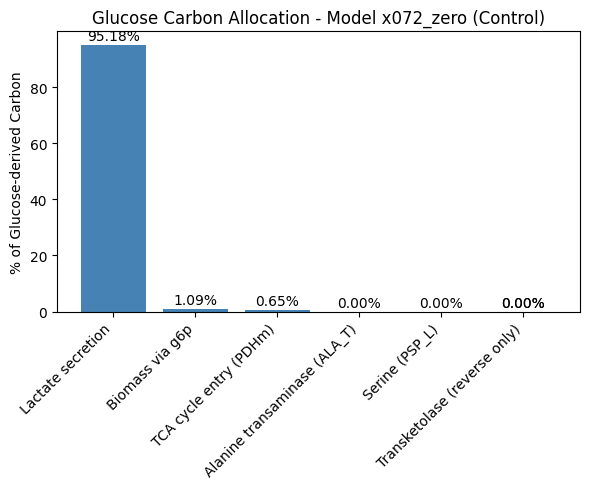

Subsystems: {'Oxidative phosphorylation'}
Metabolite: atp[m]
  Produced: 0.000313 mmol/gDW/h
  Consumed: 0.000000 mmol/gDW/h
  Net:      0.000313 mmol/gDW/h
Subsystems: {'Glycolysis/gluconeogenesis'}
Metabolite: atp[c]
  Produced: 0.110899 mmol/gDW/h
  Consumed: 0.054893 mmol/gDW/h
  Net:      0.056006 mmol/gDW/h
% ATP from TCA:       0.55%
% ATP from glycolysis: 99.45%


No defined compartments in model ContextModel. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


First Biomass pFBA: 32487.653899672394
Seahorse constrains pFBA: 52.70344401433368
Media paper constrains pFBA: 1.2322214910748601
Flux glucosa: -0.8450585042789298
Flux lactat: 0.6097327900660987


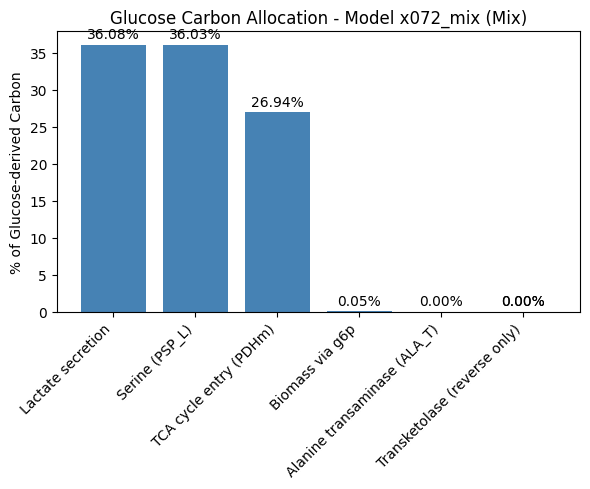

Subsystems: {'Oxidative phosphorylation'}
Metabolite: atp[m]
  Produced: 0.000394 mmol/gDW/h
  Consumed: 0.000000 mmol/gDW/h
  Net:      0.000394 mmol/gDW/h
Subsystems: {'Glycolysis/gluconeogenesis'}
Metabolite: atp[c]
  Produced: 2.739027 mmol/gDW/h
  Consumed: 1.662276 mmol/gDW/h
  Net:      1.076751 mmol/gDW/h
% ATP from TCA:       0.04%
% ATP from glycolysis: 99.96%


In [31]:
import os
import cobra
import matplotlib.pyplot as plt

# List of sample IDs and their grouping
control_ids = ['zero'] #[71, 72, 161, 162, 251, 252]
mix_ids     = ['mix'] # 'five_nor', 'five_epi'#[77, 78, 167, 168, 257, 258]

# Base directory containing your .mat files
base_dir = "/home/roger/fastcormics/data/median/"

# Container for all results
all_results = {}

# Helper to build full path
def mat_path(sample_id):
    return os.path.join(base_dir,
        f"SampleModel_{sample_id}.mat"
    )

# Analyze control models
for sid in control_ids:
    model = cobra.io.load_matlab_model(mat_path(sid))
    title = f"Glucose Carbon Allocation - Model x072_{sid} (Control)"
    res = analyze_model(
        sample_model     = model,
        conditions       = normal_conditions,
        media_constraints= media_constraints,
        plot_title       = title
    )
    all_results[f"x072_{sid}_control"] = res

# Analyze mix models
for sid in mix_ids:
    model = cobra.io.load_matlab_model(mat_path(sid))
    title = f"Glucose Carbon Allocation - Model x072_{sid} (Mix)"
    res = analyze_model(
        sample_model     = model,
        conditions       = mix_conditions,
        media_constraints= media_constraints,
        plot_title       = title
    )
    all_results[f"x072_{sid}_mix"] = res

# all_results now holds the outputs for each model:
#   keys like 'x072_71_control', 'x072_77_mix', etc.


In [32]:
all_results

{'x072_zero_control': {'glucose_flux': -0.028442915238625095,
  'lactate_flux': 0.05414386338698555,
  'allocation_df':            Reaction ID                   Description  Flux (mmol/gDW/h)  \
  0          EX_lac_L[e]             Lactate secretion            0.05414   
  2  biomass_maintenance               Biomass via g6p            0.00062   
  1                 PDHm        TCA cycle entry (PDHm)            0.00037   
  3              ALATA_L  Alanine transaminase (ALA_T)            0.00000   
  4                PSP_L                Serine (PSP_L)            0.00000   
  5                 TKT1  Transketolase (reverse only)            0.00000   
  6                 TKT2  Transketolase (reverse only)            0.00000   
  
     % of Glucose-derived Carbon  
  0                        95.18  
  2                         1.09  
  1                         0.65  
  3                         0.00  
  4                         0.00  
  5                         0.00  
  6               

In [4]:
model = cobra.io.load_matlab_model('/home/roger/fastcormics/data/median/SampleModel_zero.mat') #71 a 74  o 161 a 164  o 251 254

No defined compartments in model ContextModel. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


In [5]:
final_cons = apply_cons(model, normal_conditions, media_constraints)

First Biomass pFBA: 36819.22750190729
Seahorse constrains pFBA: 1110.3838087371016
Media paper constrains pFBA: 81.65032899206342


In [6]:
pfba(final_cons)

,fluxes,reduced_costs
10FTHF7GLUtl,1.296277e-01,-2.000000
10FTHF7GLUtm,1.296277e-01,-2.000000
10FTHFtl,-1.296277e-01,2.000000
13DAMPPOX,0.000000e+00,-2.000000
2HBO,-1.461046e-01,2.000000
...,...,...
EX_M03131[e],-6.778495e-18,-2.000000
EX_dolichol_L[e],0.000000e+00,-2.000000
ATPS4mi,3.125380e-01,-246.701833
CYOR_u10mi,2.083587e-01,-2.000000


In [7]:
model_mix = cobra.io.load_matlab_model('/home/roger/fastcormics/data/median/SampleModel_mix.mat') #71 a 74  o 161 a 164  o 251 254

No defined compartments in model ContextModel. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


In [8]:
final_mix = apply_cons(model, mix_conditions, media_constraints)

First Biomass pFBA: 36819.22750190794
Seahorse constrains pFBA: 1435.5782148922783
Media paper constrains pFBA: 96.72406281535552


In [9]:
pfba(final_mix)

,fluxes,reduced_costs
10FTHF7GLUtl,0.252766,-2.000000
10FTHF7GLUtm,0.252766,-2.000000
10FTHFtl,-0.252766,2.000000
13DAMPPOX,0.000000,-2.000000
2HBO,0.000000,1.375000
...,...,...
EX_M03131[e],0.000000,85.606311
EX_dolichol_L[e],0.000000,-2.000000
ATPS4mi,0.394495,-330.428802
CYOR_u10mi,0.262997,-2.000000


In [13]:
# 1) Solve model and get fluxes
fluxes = pfba(sample71).fluxes.to_dict()

# 2) Define subsystem filter
tca_subsystems = {'Glycolysis/gluconeogenesis'}

# 3) Collect reactions with non-zero flux
tca_reactions = [
    rxn for rxn in sample71.reactions
    if rxn.subsystem in tca_subsystems and abs(fluxes.get(rxn.id, 0.0)) > 1e-6
]

# 4) Define the canonical glycolysis sequence
glycolysis_order = [
    "HEX1",   # Glucose → G6P
    "PGI",    # G6P ↔ F6P
    "PFK",    # F6P → FBP
    "FBA",    # FBP ↔ DHAP + G3P
    "TPI",    # DHAP ↔ G3P
    "GAPD",   # G3P ↔ 1,3BPG
    "PGK",    # 1,3BPG ↔ 3PG
    "PGM",    # 3PG ↔ 2PG
    "ENO",    # 2PG ↔ PEP
    "PYK",    # PEP → Pyruvate
    "LDH_L",  # Pyruvate ↔ Lactate
    "PDHm"    # Pyruvate → Acetyl-CoA
]

# 5) Sort by that order (reactions not in the list end up at the bottom)
tca_reactions_sorted = sorted(
    tca_reactions,
    key=lambda rxn: glycolysis_order.index(rxn.id)
                 if rxn.id in glycolysis_order else len(glycolysis_order)
)

# 6) Display
for rxn in tca_reactions_sorted:
    f = fluxes.get(rxn.id, 0.0)
    print(f"{rxn.id}: {rxn.reaction}  |  Flux: {f:.8f}")


PGI: g6p[c] <=> f6p[c]  |  Flux: 930.95922871
PFK: atp[c] + f6p[c] --> adp[c] + fdp[c] + h[c]  |  Flux: 205.14725127
FBA: fdp[c] <=> dhap[c] + g3p[c]  |  Flux: 4.54858398
TPI: dhap[c] <=> g3p[c]  |  Flux: 269.63943858
GAPD: g3p[c] + nad[c] + pi[c] <=> 13dpg[c] + h[c] + nadh[c]  |  Flux: 1000.00000000
PGK: 3pg[c] + atp[c] <=> 13dpg[c] + adp[c]  |  Flux: -255.07549343
PGM: 2pg[c] <=> 3pg[c]  |  Flux: -1000.00000000
ENO: 2pg[c] <=> h2o[c] + pep[c]  |  Flux: 1000.00000000
PYK: adp[c] + h[c] + pep[c] --> atp[c] + pyr[c]  |  Flux: 1000.00000000
LDH_L: lac_L[c] + nad[c] <=> h[c] + nadh[c] + pyr[c]  |  Flux: 1000.00000000
ALDD2xm: acald[m] + h2o[m] + nad[m] --> ac[m] + 2.0 h[m] + nadh[m]  |  Flux: 195.63026824
r0173: lac_L[x] + nad[x] <=> h[x] + nadh[x] + pyr[x]  |  Flux: -1000.00000000
r0355: datp[c] + glc_D[c] --> dadp[c] + g6p[c] + h[c]  |  Flux: 2.97633273
PGMT: g1p[c] <=> g6p[c]  |  Flux: 974.82362590


In [20]:
#find_react(sample71, 'EX_glc_D[e]')
find_met(sample71, "glc_D[e]") 

In [133]:
# Print all unique subsystem names
subsystems = set(r.subsystem for r in final_cons.reactions)
for s in sorted(subsystems):
    print(s)


Alanine and aspartate metabolism
Aminosugar metabolism
Androgen and estrogen synthesis and metabolism
Arachidonic acid metabolism
Arginine and proline metabolism
Beta-Alanine metabolism
Bile acid synthesis
Biotin metabolism
Blood group synthesis
Butanoate metabolism
C5-branched dibasic acid metabolism
Cholesterol metabolism
Chondroitin sulfate degradation
Chondroitin synthesis
Citric acid cycle
CoA catabolism
CoA synthesis
D-alanine metabolism
Drug metabolism
Eicosanoid metabolism
Exchange/demand reaction
Fatty acid oxidation
Fatty acid synthesis
Folate metabolism
Fructose and mannose metabolism
Galactose metabolism
Glutamate metabolism
Glutathione metabolism
Glycerophospholipid metabolism
Glycine, serine, alanine, and threonine metabolism
Glycolysis/gluconeogenesis
Glycosphingolipid metabolism
Glyoxylate and dicarboxylate metabolism
Heme degradation
Heme synthesis
Inositol phosphate metabolism
Keratan sulfate degradation
Keratan sulfate synthesis
Leukotriene metabolism
Lysine metaboli

In [35]:
def block_reactions(model, reaction_ids):
    new_model = model.copy()
    for rid in reaction_ids:
        try:
            rxn = model.reactions.get_by_id(rid)
            rxn.lower_bound = 0.0
            rxn.upper_bound = 0.0
        except KeyError:
            pass
    return new_model


In [113]:
# Other reactions to block in the paper
reactions_to_block = [
    "r0081", "r0122", "r0153", "r0165", "r0173", "r0202", "r0280", "r0354", "r0355",
    "r0413", "r0509", "r2520", "r0885", "ICDHyrm", "SUCOASm", "FUM", "DNPt1m", "DNPt2m", 
    "DNPt3m", "DNPt4m", "DNPt5m", "DNPt6m", "DNPt7m", "DNPt8m", "DNPt9m", "DNPt10m",
    "DNPt11m", "DNPt12m", "DNPt13m", "DNPt14m", "DNPt15m", "DNPt16m", "DNPt17m",
    "DNPt18m", "DNPt19m", "DNPt20m", "DNPt21m", "DNPt22m", "DNPt23m", "DNPt24m",
    "DNPt25m", "DNPt26m", "DNPt27m", "DNPt28m", "DNPt29m", "DNPt30m", "DNPt31m",
    "DNPt32m", "DNPt33m", "DNPt34m", "DNPt35m", "DNPt36m", "DNPt37m", "DNPt38m",
    "DNPt39m", "DNPt40m", "DNPt41m", "DNPt42m", "DNPt43m", "DNPt44m", "DNPt45m",
    "DNPt46m", "DNPt47m", "DNPt48m", "DNPt49m", "DNPt50m", "DNPt51m", "DNPt52m",
    "DNPt53m", "DNPt54m", "DNPt55m", "DNPt56m", "DNPt57m", "DNPt58m", "DNPt59m",
    "DNPt60m", "DNPt61m", "DNPt62m", "DNPt63m", "r1453", "PALFATPtc",
    "RTOTAL2FATPc_pmt", "RTOTALFATPc_pmt", "RTOTAL3FATPc_pmt"
]

# Apply to your model
#new = block_reactions(s71_cons, reactions_to_block)


In [ ]:
# RE0344C, RE0344X  those should be 0 to 1